#### **imports**

In [1]:
import pickle
import sys
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid
from collections import OrderedDict
from collections import Counter
import shap

# Set the random seed
np.random.seed(123)
random_state = 123

# Traditional
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter

# Tree-Based
from sksurv.ensemble import RandomSurvivalForest

# NN
from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv
from auton_survival.models.dsm import DeepSurvivalMachines
import torchtuples as tt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from lifelines.utils import concordance_index

# Evaluation
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

# Add the outer directory
sys.path.append('../')
from eval_surv_copy import EvalSurv
from torch.optim.lr_scheduler import StepLR

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#### **Load Data**

In [2]:
# Read the pickled DataFrames
with open('data/x_train.pickle', 'rb') as file:
    x_train = pickle.load(file)
with open('data/x_test.pickle', 'rb') as file:
    x_test = pickle.load(file)
with open('data/x_val.pickle', 'rb') as file:
    x_val = pickle.load(file)

# Read the pickled DataFrame
with open('data/consolidated_pat_tbl.pickle', 'rb') as file:
    consolidated_pat_tbl = pickle.load(file)

#### **Non-Param**

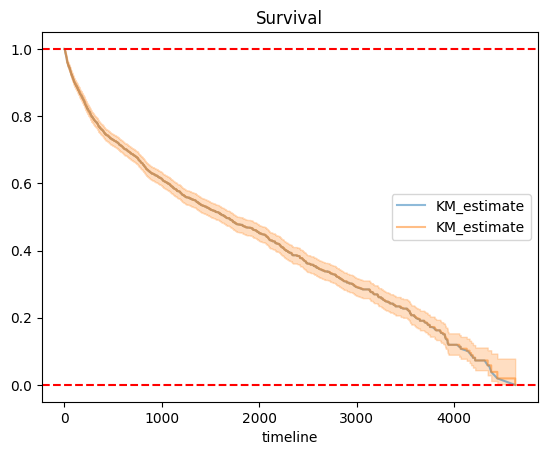

In [3]:
kmf = KaplanMeierFitter()

T = x_train["time_to_event"]
E = x_train["death"]

kmf.fit(T, event_observed=E)

kmf.survival_function_.plot(alpha = 0.5)

plt.title('Survival');

kmf.plot_survival_function(alpha = 0.5);

# Drawing a horizontal line at y = 7
plt.axhline(y=0., color='r', linestyle='--')
plt.axhline(y=1., color='r', linestyle='--')

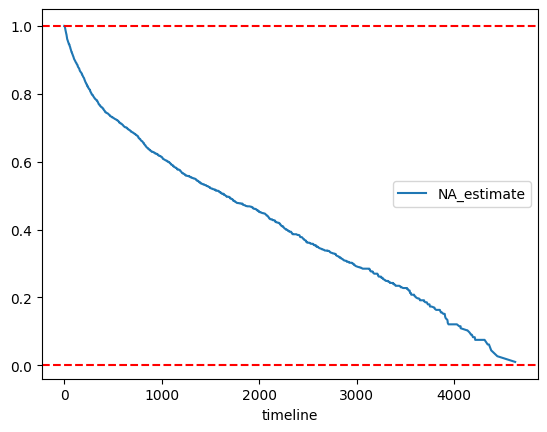

In [4]:
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)
np.exp(-naf.cumulative_hazard_).plot()
# naf.plot_survival_function()

# Drawing a horizontal line at y = 7
plt.axhline(y=0., color='r', linestyle='--')
plt.axhline(y=1., color='r', linestyle='--')

#### **Semi-Param**

In [5]:
cph = CoxPHFitter(penalizer = 0.1)
cph.fit(x_train, duration_col='time_to_event', event_col='death', fit_options = {'step_size':0.1})
# cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4242 total observations, 2835 right-censored observations>

<Axes: >

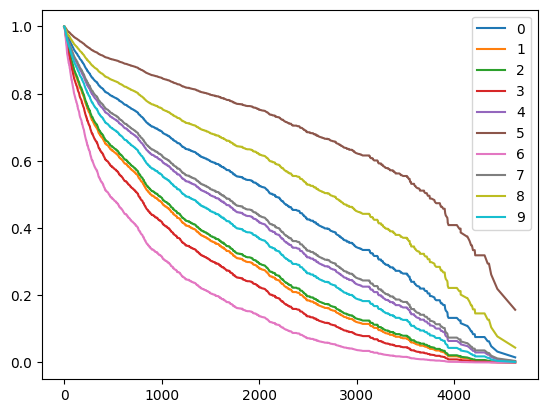

In [6]:
cph.predict_survival_function(x_test.iloc[:10]).plot()

shapes : (1060, 1060, 1060, 1060)
td-concordance 0.6806386556873991
integrated brier score 0.16855112566668323


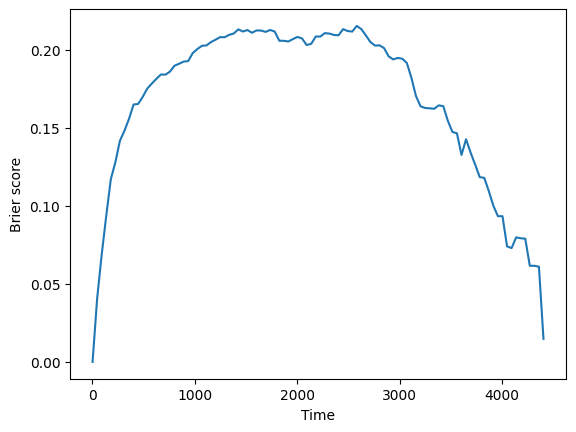

In [7]:
## td-concordance

surv_cph = cph.predict_survival_function(x_test.iloc[: , :-2])

from eval_surv_copy import EvalSurv
ev = EvalSurv(pd.DataFrame(surv_cph), x_test['time_to_event'].to_numpy(), x_test['death'].to_numpy(), censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(x_test['time_to_event'].min(), x_test['time_to_event'].max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **Param**

In [8]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer = 0.01)
eps = 1e-8
x_train['time_to_event'] = x_train['time_to_event'] + eps
aft.fit(x_train, duration_col='time_to_event', event_col='death')

# aft.print_summary(3)  # access the results using aft.summary

<lifelines.WeibullAFTFitter: fitted with 4242 total observations, 2835 right-censored observations>

<Axes: >

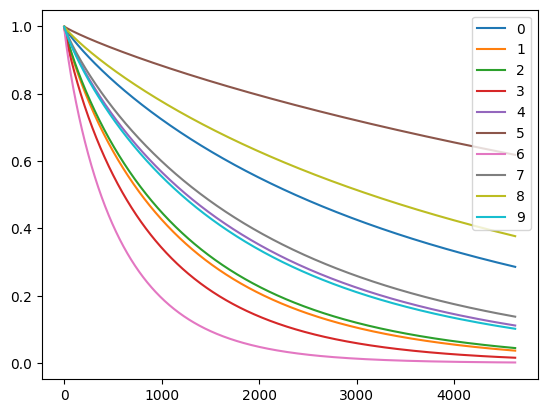

In [9]:
aft.predict_survival_function(x_test.iloc[:10]).plot()

shapes : (1060, 1060, 1060, 1060)
td-concordance 0.6804510522542563
integrated brier score 0.17485628761616817


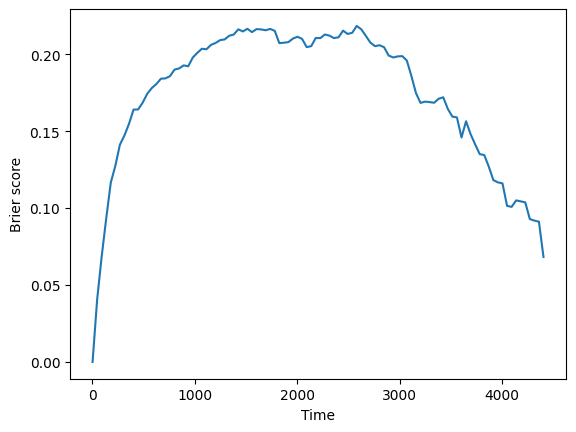

In [10]:
## td-concordance

surv_aft = aft.predict_survival_function(x_test.iloc[: , :-2])

from eval_surv_copy import EvalSurv
ev = EvalSurv(pd.DataFrame(surv_aft), x_test['time_to_event'].to_numpy(), x_test['death'].to_numpy(), censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(x_test['time_to_event'].min(), x_test['time_to_event'].max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **RSF**

In [11]:
# Train - Create a structured array
y_train = np.array([(x, y) for x, y in zip(x_train['death'].astype('bool') , x_train['time_to_event'])],
                            dtype=[('death', bool) , ('time_to_event', int)])

# Test - Create a structured array
y_test = np.array([(x, y) for x, y in zip(x_test['death'].astype('bool') , x_test['time_to_event'])],
                            dtype=[('death', bool) , ('time_to_event', int)])

# Val - Create a structured array
y_val = np.array([(x, y) for x, y in zip(x_val['death'].astype('bool') , x_val['time_to_event'])],
                            dtype=[('death', bool) , ('time_to_event', int)])


In [12]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=1234, oob_score = True
)
rsf.fit(x_train.iloc[: , :-2], y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, oob_score=True,
                     random_state=1234)

In [13]:
# Concordance
rsf.score(x_test.iloc[: , :-2], y_test) , rsf.score(x_val.iloc[: , :-2], y_val)

(0.6948965166062538, 0.7088042024923749)

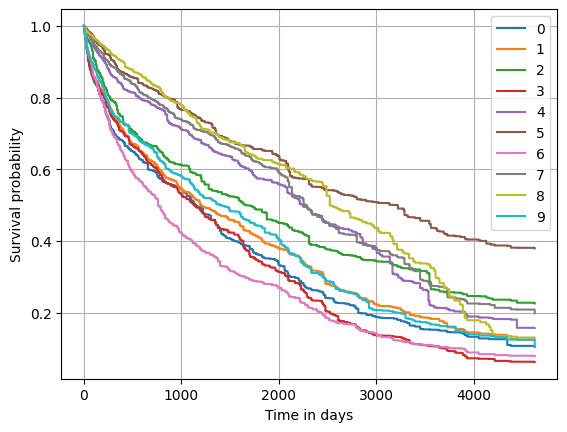

In [14]:
surv_10 = rsf.predict_survival_function(x_test.iloc[: , :-2][:10], return_array=True)

for i, s in enumerate(surv_10):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

shapes : (1060, 1060, 1060, 1060)
td-concordance 0.6975832657737636
integrated brier score 0.19566007173335645


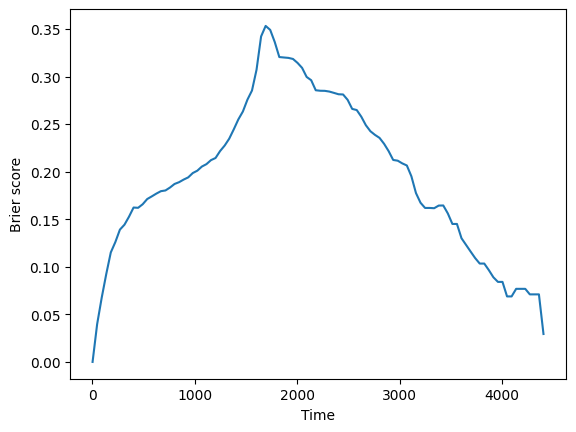

In [15]:
## td-concordance

surv_rsf = rsf.predict_survival_function(x_test.iloc[: , :-2], return_array=True)

from eval_surv_copy import EvalSurv
ev = EvalSurv(pd.DataFrame(surv_rsf.T), x_test['time_to_event'].to_numpy(), x_test['death'].to_numpy(), censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(x_test['time_to_event'].min(), x_test['time_to_event'].max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **PyCox**

0:	[0s / 0s],		train_loss: 1.6755,	val_loss: 1.5636
1:	[0s / 0s],		train_loss: 1.4759,	val_loss: 1.4093
2:	[0s / 1s],		train_loss: 1.2774,	val_loss: 1.1939
3:	[0s / 1s],		train_loss: 1.0541,	val_loss: 0.9681
4:	[0s / 1s],		train_loss: 0.8898,	val_loss: 0.8546
5:	[0s / 1s],		train_loss: 0.8021,	val_loss: 0.7878
6:	[0s / 1s],		train_loss: 0.7468,	val_loss: 0.7568
7:	[0s / 1s],		train_loss: 0.7304,	val_loss: 0.7530
8:	[0s / 1s],		train_loss: 0.7215,	val_loss: 0.7422
9:	[0s / 1s],		train_loss: 0.6979,	val_loss: 0.7354
10:	[0s / 1s],		train_loss: 0.6978,	val_loss: 0.7284
11:	[0s / 1s],		train_loss: 0.6903,	val_loss: 0.7414
12:	[0s / 1s],		train_loss: 0.6730,	val_loss: 0.7350
13:	[0s / 1s],		train_loss: 0.6843,	val_loss: 0.7320
14:	[0s / 1s],		train_loss: 0.6753,	val_loss: 0.7242
15:	[0s / 1s],		train_loss: 0.6803,	val_loss: 0.7365
16:	[0s / 1s],		train_loss: 0.6739,	val_loss: 0.7187
17:	[0s / 2s],		train_loss: 0.6734,	val_loss: 0.7179
18:	[0s / 2s],		train_loss: 0.6621,	val_loss: 0.7220
19:

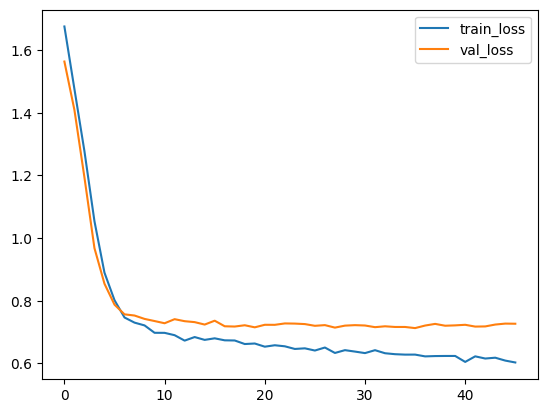

In [16]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

# one liner func
get_target = lambda df: (df['time_to_event'].values, df['death'].values)
y_train = labtrans.fit_transform(*get_target(x_train))
y_val = labtrans.transform(*get_target(x_val))

train = (x_train.iloc[: , :-2].to_numpy().astype('float32'), y_train)
val = (x_val.iloc[: , :-2].to_numpy().astype('float32'), y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(x_test)

in_features = x_train.iloc[: , :-2].shape[1]
num_nodes = [256,256]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.5

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.002), duration_index=labtrans.cuts)

batch_size = 256
epochs = 500
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(x_train.iloc[:,:-2].to_numpy().astype('float32'), y_train, batch_size, epochs, callbacks, val_data=val)

_ = log.plot()

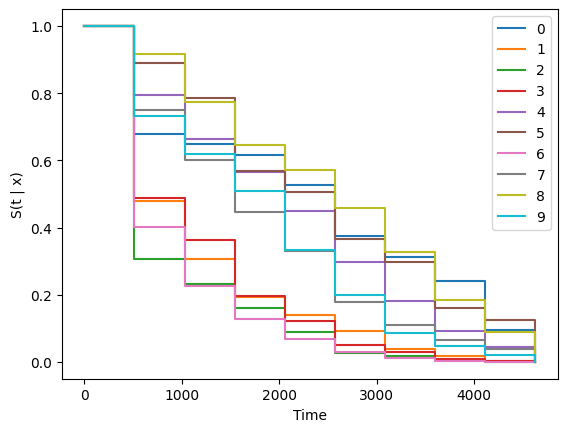

In [17]:
surv = model.predict_surv_df(x_test.iloc[: , :-2].to_numpy().astype('float32'))

surv.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

shapes : (1060, 1060, 1060, 1060)
td-concordance 0.5951115905421069
integrated brier score 0.1770723877598344


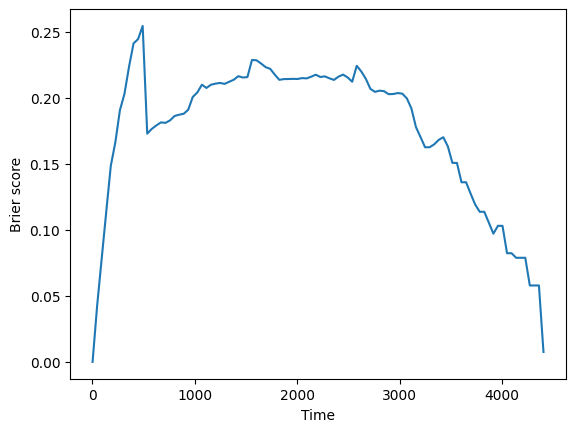

In [18]:
from eval_surv_copy import EvalSurv
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **Deep Survival Machines**

In [19]:
import auton_survival
from auton_survival import datasets
from auton_survival.preprocessing import Preprocessor
from auton_survival.models.dsm import DeepSurvivalMachines
import numpy as np

# horizons = [0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.0]
# times = np.quantile(consolidated_pat_tbl['time_to_event'].to_numpy()[consolidated_pat_tbl['death'].to_numpy()==1], horizons).tolist()
times = list(labtrans.cuts[:])
# times

In [20]:
param_grid = {'k' : [3,4,6],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [1e-4, 1e-3],
              'layers' : [ [], [100], [100, 100] ]
             }

params = ParameterGrid(param_grid)

models = []
for param in params:
    model = DeepSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 layers = param['layers'])
    # The fit method is called to train the model
    model.fit(x_train.iloc[: , :-2].to_numpy(), x_train['time_to_event'].to_numpy(), x_train['death'].to_numpy() ,
              iters = 100 , 
              learning_rate = param['learning_rate']
            )
    models.append([[model.compute_nll(x_val.iloc[: , :-2].to_numpy(), x_val['time_to_event'].to_numpy(), x_val['death'].to_numpy()), 
                    model]])
best_model = min(models)
model = best_model[0][1]

 20%|██        | 20/100 [00:02<00:11,  6.73it/s]


In [21]:
# Inference
out_risk = model.predict_risk(x_test.iloc[: , :-2].to_numpy().astype('float64'), times)
out_survival = model.predict_survival(x_test.iloc[: , :-2].to_numpy().astype('float64'), times)

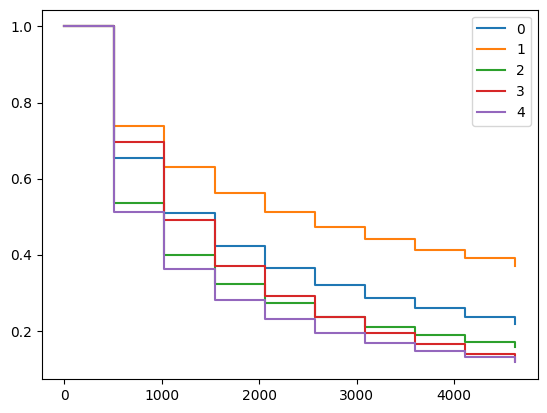

In [22]:
for i , surv in enumerate(out_survival[20:25 , :]):
    plt.step(times , surv , where = 'post' , label = i)
    plt.legend()

shapes : (1060, 1060, 1060, 1060)
td-concordance 0.6457310168776088
integrated brier score 0.27113140034554417


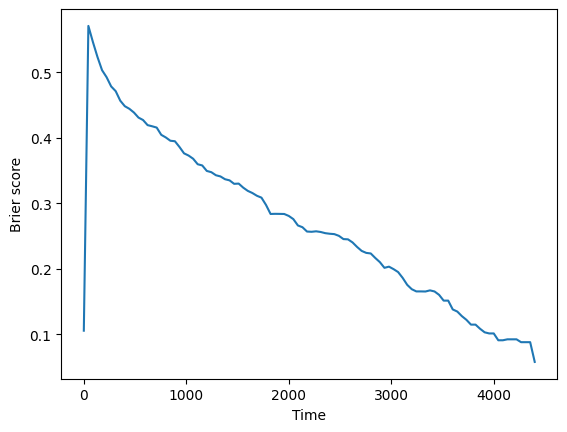

In [23]:
from eval_surv_copy import EvalSurv
ev = EvalSurv(pd.DataFrame(out_survival.T), durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **DeepSurv**

In [24]:
# Simple feedforward NN to implement DeepSurv

class MLP(nn.Module):
    def __init__(self , input_size , hidden_size , output_size , dropout_rate = 0.1):
        super(MLP , self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self , x):
        # forward pass
        output = self.network(torch.Tensor(x))
        return output

In [25]:
class generic_Loss(torch.nn.Module):
    '''
    Generic Loss Function
    '''
    def PartialLogLikelihood(self , logits, fail_indicator, ties = 'noties'):
        '''
        fail_indicator: 1 if the sample fails, 0 if the sample is censored.
        logits: raw output from model 
        ties: 'noties' or 'efron' or 'breslow'
        reference -> https://github.com/runopti/stg/blob/master/python/stg/losses.py
        '''
        logL = 0
        # pre-calculate cumsum
        # cumsum_y_pred = torch.cumsum(logits, 0)
        hazard_ratio = torch.exp(logits)
        cumsum_hazard_ratio = torch.cumsum(hazard_ratio, 0)
        if ties == 'noties':
            log_risk = torch.log(cumsum_hazard_ratio)
            likelihood = logits - log_risk
            # dimension for E: np.array -> [None, 1]
            uncensored_likelihood = likelihood * fail_indicator
            logL = -torch.sum(uncensored_likelihood)
        else:
            raise NotImplementedError()
        # negative average log-likelihood
        observations = torch.sum(fail_indicator, 0)
        return 1.0*logL / observations

In [26]:
class MyDataset(Dataset):
    '''
    simple data set class
    '''
    def __init__(self, features, events):
        self.data = features
        self.events = events
        assert self.data.shape[0] == self.events.shape[0] , 'shapes must match!'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        cov = self.data[index] # covariates
        eve = self.events[index] # events
        return cov , eve

In [27]:
input_size = x_train.iloc[: , :-2].shape[1]
output_size = 1 # the output is the hazard

# Create an instance of your custom dataset
dataset = MyDataset(torch.Tensor(x_train.iloc[: , :-2].to_numpy()).to(torch.float32), 
                    torch.Tensor(x_train.iloc[: , -1].to_numpy()).to(torch.float32)
                    )

# Create a data loader for batching and shuffling
batch_size = 25
num_epochs = 1000
learning_rate = 1e-5
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
patience = 50
dropout = 0.4
momentum = 0.9

# build net
# net = MLP(input_size , hidden_size , output_size)
net = MLP(
    input_size =  input_size, 
    hidden_size = 100 , 
    output_size = output_size,
    dropout_rate = dropout
)

# init optim - with Nesterov momentum
optimizer = torch.optim.SGD(net.parameters() , lr = learning_rate, momentum = momentum, nesterov = True)

# Create the StepLR scheduler
# The learning rate will be multiplied by 'gamma' every 'step_size' epochs
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [28]:
l = generic_Loss()

best_loss = np.Inf

cov_val = torch.Tensor(x_val.iloc[: , :-2].to_numpy()).to(torch.float32)
eve_val = torch.Tensor(x_val.iloc[: , -1].to_numpy()).to(torch.float32)

# Training loop
for epoch in range(num_epochs):
    for batch_id , (cov , eve) in enumerate(dataloader):
        # Prime for training
        net.train()

        # forward pass
        phi_train = net(cov)

        # get loss
        loss = l.PartialLogLikelihood(logits = phi_train , fail_indicator = eve)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Early stopping
        # Prime for evaluation
        net.eval()
        with torch.no_grad():
            phi_val = net(cov_val)
            val_loss = l.PartialLogLikelihood(logits = phi_val , fail_indicator = eve_val)
        
        # Check if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping condition is met
        if counter >= patience:
            # print(f"Early stopping at epoch {epoch}.")
            break
    
    # Apply learning rate decay at the end of each epoch
    scheduler.step()

    if (epoch%50==0): print(f"Epoch {epoch+1}: Training Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}") 

Epoch 1: Training Loss: 60.0973, Val Loss: 8330.0186
Epoch 51: Training Loss: 59.9014, Val Loss: 8293.9355
Epoch 101: Training Loss: 62.2184, Val Loss: 8314.3672
Epoch 151: Training Loss: 63.3938, Val Loss: 8380.2432
Epoch 201: Training Loss: 53.7091, Val Loss: 8296.4678
Epoch 251: Training Loss: 59.9026, Val Loss: 8275.9766
Epoch 301: Training Loss: 59.5646, Val Loss: 8313.9805
Epoch 351: Training Loss: 64.2775, Val Loss: 8321.8506
Epoch 401: Training Loss: 60.3039, Val Loss: 8406.2588
Epoch 451: Training Loss: 62.9277, Val Loss: 8304.4912
Epoch 501: Training Loss: 65.4996, Val Loss: 8263.5400
Epoch 551: Training Loss: 60.3415, Val Loss: 8289.6826
Epoch 601: Training Loss: 60.9936, Val Loss: 8335.8105
Epoch 651: Training Loss: 62.5428, Val Loss: 8317.7002
Epoch 701: Training Loss: 65.0050, Val Loss: 8298.0273
Epoch 751: Training Loss: 60.2328, Val Loss: 8269.0928
Epoch 801: Training Loss: 59.6886, Val Loss: 8286.2764
Epoch 851: Training Loss: 67.1060, Val Loss: 8305.5205
Epoch 901: Tr

In [29]:
cov_test = torch.Tensor(x_test.iloc[: , :-2].to_numpy()).to(torch.float32)
dur_test = torch.Tensor(x_test.iloc[: , -2].to_numpy()).to(torch.float32)
eve_test = torch.Tensor(x_test.iloc[: , -1].to_numpy()).to(torch.float32)
print(f'test shape: {cov_test.shape}')

with torch.no_grad():
    risk_test = torch.exp(net(cov_test))

concordance_index(dur_test, risk_test, eve_test) 

test shape: torch.Size([1060, 42])


0.40466060528907677

#### **My Model**

#### **Time Independent**

Flow
_____
1. measure similarity
2. cluster
3. build cluster-wise nn
4. predict

In [3]:
# Clustering
from sklearn.cluster import KMeans

# Specify the number of clusters (K)
_clusters = 1

# Create a KMeans instance and fit the data
kmeans = KMeans(n_clusters=_clusters , n_init = 'auto')
kmeans.fit(x_train.iloc[: , :-2])

# Add cluster
x_train['cluster'] = kmeans.labels_

x_train_grouped = x_train.groupby('cluster')

# drop cluster to avoid shape problems
x_train.drop('cluster' , axis = 1 , inplace = True)

assert x_train.shape[1] == x_val.shape[1] == x_test.shape[1]

In [4]:
def plot_cluster_hist(arr: np.array):
    cluster_counts = Counter(arr)
    # Sort the Counter object by keys in ascending order
    sorted_countes = OrderedDict(sorted(cluster_counts.items()))
    
    # Extract the category labels and their corresponding counts
    labels = list(sorted_countes.keys())
    counts = list(sorted_countes.values())

    # Plot the histogram
    plt.bar(labels, counts);

    # Set the labels and title
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title('Categorical Histogram')
    plt.xticks(labels)

    for i, value in enumerate(counts):
        plt.text(i, value + 1, str(value), ha='center', va='bottom')

    plt.show()

In [5]:
test_clusters = kmeans.predict(x_test.iloc[: , :-2])
# plot_cluster_hist(test_clusters)

# Add cluster
x_test['cluster'] = test_clusters

x_test_grouped = x_test.groupby('cluster')

# drop cluster to avoid shape problems
x_test.drop('cluster' , axis = 1 , inplace = True)

val_clusters = kmeans.predict(x_val.iloc[: , :-2])
# plot_cluster_hist(test_clusters)

# Add cluster
x_val['cluster'] = val_clusters

x_val_grouped = x_val.groupby('cluster')

# drop cluster to avoid shape problems
x_val.drop('cluster' , axis = 1 , inplace = True)

In [90]:
class generic_Loss(torch.nn.Module):
    '''
    Generic Loss Function
    '''
    def __init__(self, reduction: str = 'mean') -> None:
        super().__init__()
        self.reduction = reduction

    def nll_logistic_hazard(self , logits , targets , dur_idx):
        '''
        logits - parameterized inv.logit(hazards) from nn
        targets - survival matrix 
        '''
        logits = torch.Tensor(logits)
        targets = torch.Tensor(targets)
        dur_idx = torch.Tensor(dur_idx).to(torch.int64).view(-1 , 1)

        loss = F.binary_cross_entropy_with_logits(input = logits , target = targets , reduction = 'none')
        
        assert loss.shape == targets.shape , 'must match'

        # cumulative hazards
        loss = loss.cumsum(1)
        loss = loss.gather(1, dur_idx)
        
        return loss.view(-1).mean()

    def c_index_lbo_loss(self , logits , times , events):
        '''
        here logits are used to form the predicted survival times
        '''
        _haz = torch.sigmoid(logits)
        _survival = torch.cumprod(1 - _haz , dim = 1)

        # get last survival proba    
        last_pred_survival = _survival[: , -1]
            
        # get comparable mask
        comp_mask = self.get_comparable_mask(times , events)
            
        # get loss - in order to maximise the LBO of the C-index, its negative needs to be minimized
        loss = -self.cindex_lower_bound(comp_mask , last_pred_survival , times)

        return loss

    def cindex_lower_bound(self , comp_mask, pred_times, times):
        '''
        comp_mask - comparable mask (no need for times and events separately)
        pred_times - predicted survival times / (or survival probabilities)
        '''
        # Get order
        _, order = torch.sort(times)
        
        # Convert comp_mask and pred_times to PyTorch tensors - hen order accordingly
        pred_times_tensor = pred_times[order]

        # Lower Bound
        lb = torch.sum(comp_mask * (1 + torch.log(torch.sigmoid(pred_times_tensor - pred_times_tensor.view(-1, 1))) / torch.log(torch.tensor(2)))) / torch.sum(comp_mask)
            
        # Exact C index
        cindex = torch.sum(comp_mask * (pred_times_tensor - pred_times_tensor.view(-1, 1)) > 0) / torch.sum(comp_mask)
        # print(lb , cindex)
        assert lb <= cindex, 'not a lower bound'

        # add gradient tracking
        lb = lb.clone().detach().requires_grad_(True)
            
        return lb

    def get_comparable_mask(self , times, events):
        # Get order
        _, order = torch.sort(times)
        eve_ordered = events[order]

        # Build cross matrix
        cross_mat = torch.triu((torch.outer(eve_ordered, eve_ordered) + eve_ordered.view(-1, 1)).bool()).int()
        
        # Set all diagonal elements to zero
        cross_mat.fill_diagonal_(0)

        return cross_mat

In [91]:
class MLP(nn.Module):
    def __init__(self , input_size , hidden_size , output_size , dropout_rate = 0.1):
        super(MLP , self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self , x):
        # forward pass
        output = self.network(torch.Tensor(x).to(torch.float32))
        return output   

In [92]:
class MyDataset(Dataset):
    '''
    simple data set class
    '''
    def __init__(self, features, duration_index , durations, events):
        self.data = features
        self.durations = durations
        self.duration_index = duration_index
        self.events = events
        assert self.data.shape[0] == self.duration_index.shape[0] == self.durations.shape[0] == self.events.shape[0] , 'shapes must match!'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        cov = self.data[index] # covariates
        dur_idx = self.duration_index[index] # duration index
        dur = self.durations[index] # durations
        eve = self.events[index] # events
        return cov , dur_idx , dur , eve

In [93]:
class Surv_Matrix:
    def __init__(self , duration_index , events , q_cuts=10):
        self.duration_index = duration_index
        self.events = events
        self.q_cuts = q_cuts
    
    def make_survival_matrix(self):
        '''
        converts durations and index into a matrix denoting time of event
        this is the y_ij matrix as shown in Kvamme's paper
        '''
        self.surv_matrix = torch.eye(self.q_cuts)[self.duration_index]
        self.surv_matrix = self.surv_matrix*self.events.reshape(-1 , 1) # censoring mask
        return self.surv_matrix

In [94]:
class Transforms:
    def __init__(self , durations):
        self.durations = durations
        
    def discrete_transform(self , _cuts):
        '''
        cut at even spaces
        '''
        self.bin_edges = np.linspace(self.durations.min() , self.durations.max() , _cuts) # right-side edges of the bins
        self.duration_index = np.searchsorted(a = self.bin_edges , v = self.durations)
        self.n_duration_index = self.duration_index.max()+1
        # print(self.n_duration_index)
        assert self.n_duration_index == _cuts , 'must match'
        return self.duration_index

In [95]:
q_cuts = 15 # number of discretized durations

# Prepare val and test data
get_target = lambda df: (df['time_to_event'].values, df['death'].values)
y_test_dur , y_test_event = get_target(x_test)
y_val_dur , y_val_event = get_target(x_val)

t_test = Transforms(durations = y_test_dur)
dur_idx_test = t_test.discrete_transform(_cuts = q_cuts)

t_val = Transforms(durations = y_val_dur)
dur_idx_val = t_val.discrete_transform(_cuts = q_cuts)

# # We don't need to transform the test labels
# durations_test, events_test = get_target(x_test)

In [96]:
input_size = x_train.iloc[: , :-2].shape[1]
hidden_size = 25
output_size = t_test.n_duration_index
alpha = 0.01

# Create a data loader for batching and shuffling
batch_size = 256
num_epochs = 1000
learning_rate = 0.001
shuffle = True
patience = 20
dropout = 0.5

# build net(s)
nets = []

# init as many networks as there are clusters
for grp in x_train_grouped.groups.keys():
    # init net
    mlp = MLP(input_size , hidden_size , output_size , dropout_rate = dropout)
    # init optim
    optimizer = torch.optim.Adam(mlp.parameters() , lr = learning_rate)
    
    # # init optim - with Nesterov momentum
    # optimizer = torch.optim.SGD(net.parameters() , lr = learning_rate, momentum = momentum, nesterov = True)

    # # Create the StepLR scheduler
    # # The learning rate will be multiplied by 'gamma' every 'step_size' epochs
    # scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # append
    nets.append((mlp , optimizer))

In [97]:
sm_val = Surv_Matrix(duration_index = dur_idx_val , events = y_val_event , q_cuts = q_cuts)
surv_mat_val = sm_val.make_survival_matrix()

# init loss
l = generic_Loss()

# init loss for early stopping
best_loss = np.Inf

In [98]:
for i , grp in enumerate(x_train_grouped.groups.keys()): 
    print(f'training cluster {i}')
    # get features, death time and event indicator
    features = x_train_grouped.get_group(grp)
    
    y_train_dur , y_train_event = get_target(features)

    t_train = Transforms(durations = y_train_dur)
    dur_idx = t_train.discrete_transform(_cuts = q_cuts)

    features = features.iloc[: , :-2].to_numpy() # curtail  features column

    # Create an instance of your custom dataset
    dataset = MyDataset(features, dur_idx , y_train_dur , y_train_event) # need to change outcomes[0] to indexed version
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    # get mlp and optimizer
    net = nets[i][0]
    optimizer = nets[i][1]
    # scheduler = nets[i][2]

    # Training loop
    for epoch in range(num_epochs):
        for batch_id , (patient_image , dur_idx , dur , eve) in enumerate(dataloader):

            # Prime for training
            net.train()
            
            # forward pass
            phi_train = net(patient_image)

            # make survival matrix
            sm = Surv_Matrix(duration_index = dur_idx, events = eve , q_cuts = q_cuts)
            surv_mat = sm.make_survival_matrix()        

            # get loss
            loss_1 = l.nll_logistic_hazard(logits = phi_train , targets = surv_mat , dur_idx = dur_idx)
            loss_2 = l.c_index_lbo_loss(logits = phi_train , times = dur , events = eve)
            
            # combine
            loss = alpha*loss_1 + (1-alpha)*(loss_2)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Early stopping
            with torch.no_grad():
                phi_val = net(x_val.iloc[: , :-2].to_numpy())
                val_loss_1 = l.nll_logistic_hazard(logits = phi_val, targets = surv_mat_val , dur_idx = dur_idx_val)
                val_loss_2 = l.c_index_lbo_loss(logits = phi_val , times = torch.Tensor(y_val_dur) , events = torch.Tensor(y_val_event))

                # combine
                val_loss = alpha*val_loss_1 + (1-alpha)*(val_loss_2)

            # Check if validation loss has improved
            if val_loss < best_loss:
                best_loss = val_loss
                counter = 0
            else:
                counter += 1

            # Check if early stopping condition is met
            if counter >= patience:
                # print(f"Early stopping at epoch {epoch}.")
                break

        if (epoch%50==0): print(f"Epoch {epoch}: Training Loss: {loss.item():.7f}, Val Loss: {val_loss.item():.7f}") 


training cluster 0


Epoch 0: Training Loss: 0.0280117, Val Loss: 0.0287833
Epoch 50: Training Loss: 0.0031716, Val Loss: 0.0058086
Epoch 100: Training Loss: -0.0038292, Val Loss: -0.0027460
Epoch 150: Training Loss: -0.0106596, Val Loss: -0.0008593
Epoch 200: Training Loss: 0.0038179, Val Loss: -0.0007078
Epoch 250: Training Loss: -0.0017566, Val Loss: -0.0057442
Epoch 300: Training Loss: -0.0066832, Val Loss: -0.0059646
Epoch 350: Training Loss: -0.0111500, Val Loss: -0.0046233
Epoch 400: Training Loss: 0.0063935, Val Loss: -0.0031187
Epoch 450: Training Loss: -0.0040372, Val Loss: -0.0019821
Epoch 500: Training Loss: -0.0094107, Val Loss: -0.0047710
Epoch 550: Training Loss: -0.0037758, Val Loss: -0.0022033
Epoch 600: Training Loss: 0.0011504, Val Loss: -0.0032976
Epoch 650: Training Loss: -0.0099532, Val Loss: -0.0045491
Epoch 700: Training Loss: 0.0013776, Val Loss: -0.0024436
Epoch 750: Training Loss: -0.0091519, Val Loss: -0.0062275
Epoch 800: Training Loss: 0.0003900, Val Loss: -0.0082163
Epoch 850

**Testing**

In [99]:
# Testing
surv = [] # length will be equal to number of cluster
mc_iter = 100

# init empty lists for duration and event 
y_test_dur = []
y_test_event = []

# predict for each cluster
for i , grp in enumerate(x_test_grouped.groups.keys()):
    
    # get features, death time and event indicator
    features = x_test_grouped.get_group(grp)

    # get death time and event indicator
    y_test_dur_ , y_test_event_ = get_target(features)
    y_test_dur.append(y_test_dur_)
    y_test_event.append(y_test_event_)

    # curtail features matrix
    features = features.iloc[: , :-2].to_numpy()

    survival = []

    # apply Monte Carlo dropout
    for _ in range(mc_iter):
        net = nets[i][0]
        
        # Prime dropout layers
        net.train()
        
        # predict
        mc_haz = torch.sigmoid(net(features))
        mc_survival = torch.cumprod(1 - mc_haz , dim = 1).detach().numpy()

        # append survivals from different runs
        survival.append(mc_survival)
    
    # convert to 3d array
    survival = np.array(survival)
    
    surv.append(survival)


# Concatenate durations and event indicators 
y_test_dur = np.concatenate(y_test_dur , axis = 0)
y_test_event = np.concatenate(y_test_event , axis = 0)

# QCs
assert len(surv) == _clusters , 'surv matrix not matching number of clusters'
assert len(x_test) == np.sum([surv[k].shape[1] for k in range(_clusters)]) , 'test set count mismatch'

mean_ = np.concatenate([surv[k].mean(axis = 0) for k in range(_clusters)])
up_ = np.concatenate([np.quantile(surv[k] , axis = 0 , q = 0.95) for k in range(_clusters)])
low_ = np.concatenate([np.quantile(surv[k] , axis = 0 , q = 0.05) for k in range(_clusters)])

# QCs
assert mean_.shape[0] == up_.shape[0] == low_.shape[0] == y_test_dur.shape[0] == y_test_event.shape[0] , 'shape mismatch'

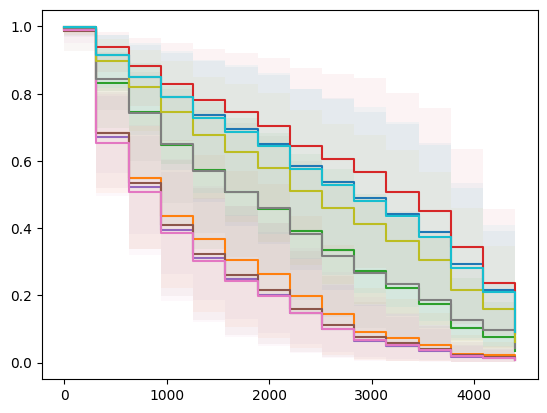

In [100]:
def plot_with_cf(mean_ , low_ , up_ , _from , _to = None):
    if _to is not None:
        for _ , (m , l , u) in enumerate(zip(mean_[_from:_to] , low_[_from:_to] , up_[_from:_to])):
            plt.step(t_test.bin_edges , m , where = 'post' , label = 'mean');
            plt.fill_between(t_test.bin_edges , l , u , step = 'post' , alpha = 0.05 , label = 'confint');
    else:
        m , l , u = mean_[_from] , low_[_from] , up_[_from]
        plt.step(t_test.bin_edges , m , where = 'post' , label = 'mean');
        plt.fill_between(t_test.bin_edges , l , u , step = 'post' , alpha = 0.05 , label = 'confint');

plot_with_cf(mean_ , low_ , up_ , _from = 40 , _to = 50)

shapes : (1060, 1060, 1060, 1060)
concordance-td: 0.6721762901274588
integrated brier score 0.3897876882194133


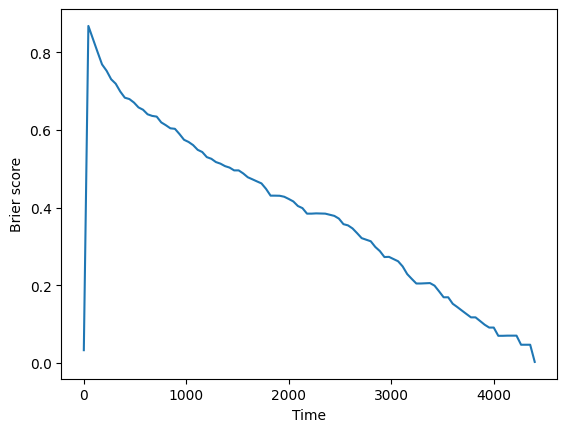

In [101]:
# Evaluation

ev_ = EvalSurv(pd.DataFrame(mean_.T) , y_test_dur , y_test_event , censor_surv='km')
print(f'concordance-td: {ev_.concordance_td()}')

time_grid = np.linspace(y_test_dur.min(), y_test_dur.max(), 100)
ev_.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev_.integrated_brier_score(time_grid) }')

**Explainer**

In [56]:
%%time
# SHAP Values
grp = 0

background = x_val_grouped.get_group(grp)
background = torch.Tensor(background.iloc[:500 , :-2].to_numpy())

testing_data = x_test_grouped.get_group(grp)
testing_data = torch.Tensor(testing_data.iloc[:500 , :-2].to_numpy()) # curtail  features column

explainer = shap.DeepExplainer(nets[grp][0] , background)
shap_values = explainer.shap_values(testing_data)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


CPU times: total: 15min 44s
Wall time: 2min 26s


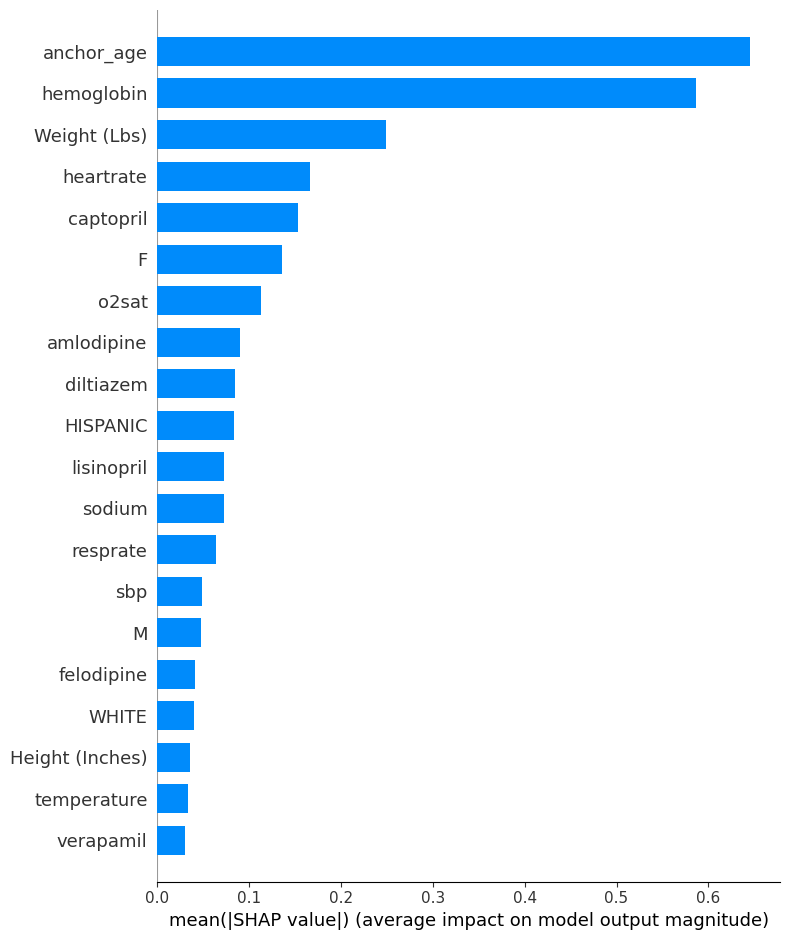

In [57]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = x_test_grouped.get_group(grp).iloc[: , :-2].columns)

In [58]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features = x_test_grouped.get_group(grp).iloc[: , :-2].columns)

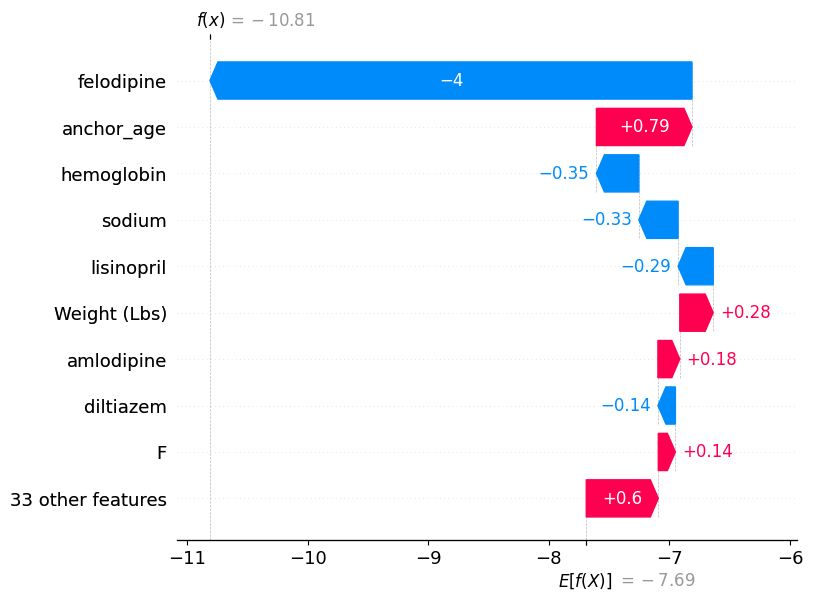

In [59]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], 
                                       feature_names = x_test_grouped.get_group(grp).iloc[: , :-2].columns)

---------------

In [44]:
# def c_index_lbo_loss(logits , times , events):
#     '''
#     here logits are used to form the predicted survival times
#     '''
#     _haz = torch.sigmoid(logits)
#     _survival = torch.cumprod(1 - _haz , dim = 1)

#     # get last survival proba    
#     last_pred_survival = _survival[: , -1]
        
#     # get comparable mask
#     comp_mask = get_comparable_mask(times , events)
        
#     # get loss
#     loss = cindex_lower_bound(comp_mask , last_pred_survival , times)

#     return -loss

# def cindex_lower_bound(comp_mask, pred_times, times):
#     '''
#     comp_mask - comparable mask (no need for times and events separately)
#     pred_times - predicted survival times / (or survival probabilities)
#     '''
#     # Get order
#     _, order = torch.sort(times)
    
#     # Convert comp_mask and pred_times to PyTorch tensors - hen order accordingly
#     pred_times_tensor = pred_times[order]

#     # Lower Bound
#     lb = torch.sum(comp_mask * (1 + torch.log(torch.sigmoid(pred_times_tensor - pred_times_tensor.view(-1, 1))) / torch.log(torch.tensor(2)))) / torch.sum(comp_mask)
        
#     # Exact C index
#     cindex = torch.sum(comp_mask * (pred_times_tensor - pred_times_tensor.view(-1, 1)) > 0) / torch.sum(comp_mask)
#     # print(lb , cindex)
#     assert lb <= cindex, 'not a lower bound'

#     # add gradient tracking
#     lb = lb.clone().detach().requires_grad_(True)
        
#     return lb

# def get_comparable_mask(times, events):
#     # Get order
#     _, order = torch.sort(times)
#     eve_ordered = events[order]

#     # Build cross matrix
#     cross_mat = torch.triu((torch.outer(eve_ordered, eve_ordered.T) + eve_ordered.view(-1, 1)).bool()).int()
    
#     # Set all diagonal elements to zero
#     cross_mat.fill_diagonal_(0)

#     return cross_mat

# def sigmoid(x):
#     return 1/(1 + torch.exp(-x))

In [ ]:
# def get_num_comparable_pairs(times , events):
#     order = np.argsort(times)
#     eve_ordered = events[order]
#     num_pairs = np.sum((np.arange(len(eve_ordered)))[::-1]*eve_ordered)
#     return num_pairs
    
# times = np.random.randint(1 , 100 , size = 10)
# events = np.random.randint(0,2,size = len(times))

# print(times , events)

# order = np.argsort(times)
# eve_ordered = events[order]
# eve_ordered

# print(times[order] , eve_ordered)

# get_num_comparable_pairs(times , events)


# def get_comparable_mask(times , events):
#     '''
#     slightly different to book definition
#     Here, (i,j) can be a comparable pair, but (j,i) may not be so
#     read the matrix as: if time at col i is uncensored and less time at col j, Matrix[i,j] = 1, otherwise 0  
#     '''
#     # get order
#     order = np.argsort(times)
#     eve_ordered = events[order]
    
#     # build cross matrix
#     cross_mat = np.triu(np.outer(eve_ordered , eve_ordered.T) + eve_ordered.reshape(-1 , 1))
#     cross_mat_mod = (cross_mat != 0).astype('int')
#     # Set all diagonal elements to zero - this is an inplace operation
#     np.fill_diagonal(cross_mat_mod, 0)
#     return cross_mat_mod


# def cindex_lower_bound(comp_mask , pred_times):
#     '''
#     comp_mask - comparable mask (no need for times and events separately)
#     pred_times - predicted times
#     '''
#     # def one line func
#     sigmoid = lambda x: 1 / (1 + np.exp(-x))

#     # Lower Bound
#     lb =  np.sum(comp_mask * (1 + np.log(sigmoid(np.subtract(pred_times , pred_times.reshape(-1 , 1))))/np.log(2)))/np.sum(comp_mask)
#     # exact C index
#     cindex = np.sum(comp_mask * ((np.subtract(pred_times , pred_times.reshape(-1 , 1)))>0))/np.sum(comp_mask)

#     assert lb <= cindex , 'not a lower bound'

#     return torch.from_numpy(lb.reshape(-1,1))

In [ ]:
# def get_comparable_mask(times, events):
#     # Convert input arrays to PyTorch tensors
#     times_tensor = torch.tensor(times)
#     events_tensor = torch.tensor(events)

#     # Get order
#     _, order = torch.sort(times_tensor)
#     eve_ordered = events_tensor[order]

#     # Build cross matrix
#     cross_mat = torch.triu((torch.outer(eve_ordered, eve_ordered.T) + eve_ordered.view(-1, 1)).bool()).int()
#     # Set all diagonal elements to zero
#     cross_mat.fill_diagonal_(0)

#     return cross_mat

In [ ]:
# def cindex_lower_bound(comp_mask, pred_times):
#     '''
#     comp_mask - comparable mask (no need for times and events separately)
#     pred_times - predicted times
#     '''
#     # Define the sigmoid function as a one-liner using PyTorch
#     sigmoid = lambda x: 1 / (1 + torch.exp(-x))

#     # Convert comp_mask and pred_times to PyTorch tensors
#     pred_times_tensor = torch.tensor(pred_times)

#     # Lower Bound
#     lb = torch.sum(comp_mask * (1 + torch.log(sigmoid(pred_times_tensor - pred_times_tensor.view(-1, 1))) / torch.log(torch.tensor(2)))) / torch.sum(comp_mask)
    
#     # Exact C index
#     cindex = torch.sum(comp_mask * (pred_times_tensor - pred_times_tensor.view(-1, 1)) > 0) / torch.sum(comp_mask)

#     assert lb <= cindex, 'not a lower bound'

#     # add gradient tracking
#     lb = lb.clone().detach().requires_grad_(True)
    
#     return lb

In [ ]:
# def c_index_lbo_loss(logits , times , events):
#     '''
#     here logits are used to form the predicted survival times
#     '''
#     _haz = torch.sigmoid(net(features))
#     _survival = torch.log(1 - _haz).cumsum(1).exp().detach().numpy()
    
#     last_pred_survival = _survival[: , -1]
#     # get comparable mask
#     comp_mask = get_comparable_mask(times , events)
    
#     # get loss
#     loss = cindex_lower_bound(comp_mask , last_pred_survival)

#     return loss

In [ ]:
# # times = np.random.randint(1 , 100 , size = 5)
# pred_times = np.random.rand(5)
# events = np.random.randint(0 , 2 , size = len(times))
# # times , pred_times , events

# comp_mask = get_comparable_mask(times , events)
# loss = cindex_lower_bound(comp_mask , pred_times)